In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# Tầng tích chập


In [37]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.block(x)

# Định nghĩa khối Dense Block

In [38]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_convs):
            layers.append(ConvBlock(in_channels + i * growth_rate, growth_rate))
        self.net = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.net:
            y = layer(x)
            x = torch.cat([x, y], dim=1)
        return x

# Định nghĩa khối Transition Block để giảm số lượng kênh

In [39]:
class TransitionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionBlock, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.block(x)

# Định nghĩa kiến trúc DenseNet nhỏ

In [40]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, num_convs_in_dense_blocks=[4, 4, 4, 4]):
        super(DenseNet, self).__init__()
        num_channels = 64
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.dense_blocks = nn.ModuleList()
        self.transition_blocks = nn.ModuleList()
        
        for i, num_convs in enumerate(num_convs_in_dense_blocks):
            self.dense_blocks.append(DenseBlock(num_convs, num_channels, growth_rate))
            num_channels += num_convs * growth_rate
            if i != len(num_convs_in_dense_blocks) - 1:
                self.transition_blocks.append(TransitionBlock(num_channels, num_channels // 2))
                num_channels = num_channels // 2
        
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, 10)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        for i in range(len(self.dense_blocks)):
            x = self.dense_blocks[i](x)
            if i < len(self.transition_blocks):
                x = self.transition_blocks[i](x)
        
        x = self.bn2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Chuẩn bị Dữ liệu:

In [41]:
transform = transforms.Compose([transforms.Resize((96, 96)),
                                transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

Train

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    train_losses, test_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        test_acc = evaluate_accuracy(model, test_loader)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    
    return train_losses, test_accuracies

def evaluate_accuracy(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [43]:
model = DenseNet(growth_rate=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)


Epoch [1/5], Loss: 0.4343, Test Accuracy: 0.8470
Epoch [2/5], Loss: 0.2738, Test Accuracy: 0.8872
Epoch [3/5], Loss: 0.2324, Test Accuracy: 0.9007
Epoch [4/5], Loss: 0.2074, Test Accuracy: 0.9100
Epoch [5/5], Loss: 0.1921, Test Accuracy: 0.9030


# Đánh giá

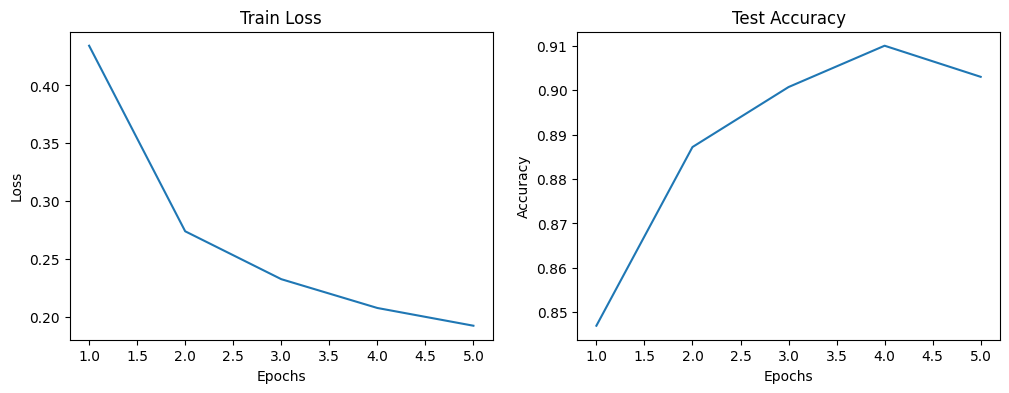

In [44]:
epochs = range(1, 6)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

# Dự đoán 1 ảnh

In [45]:
def predict_single_image(model, image):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Thêm chiều batch và đưa ảnh vào GPU
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

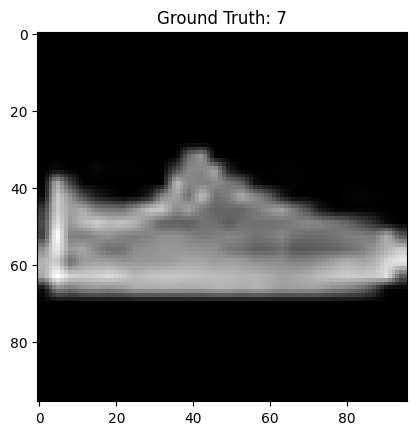

Predicted Label: 7


In [47]:
image, label = testset[12]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Ground Truth: {label}')
plt.show()

predicted_label = predict_single_image(model, image)
print(f'Predicted Label: {predicted_label}')
